In [2]:
!pip install torch-lr-finder

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_lr_finder import LRFinder
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.12/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# ==================== RESIDUAL BLOCK ====================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
# ==================== RESNET-44 MODEL ====================
class ResNet44(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet44, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def ResNet_44(num_classes=100):
    return ResNet44(ResidualBlock, [5, 5, 5, 5], num_classes=num_classes)

In [6]:
 #==================== DATA AUGMENTATION ====================
class CIFAR100Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

def get_transforms():
    # CIFAR-100 normalization
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]

    train_transform = A.Compose([
        A.PadIfNeeded(min_height=40, min_width=40, p=1.0),
        A.RandomCrop(32, 32, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.85, 1.15), translate_percent=0.1, rotate=(-15, 15), p=0.5),
        A.CoarseDropout(
            num_holes_range=(1, 1),
            hole_height_range=(16, 16),
            hole_width_range=(16, 16),
            fill=tuple([int(x*255) for x in mean]),
            p=0.3
        ),
        A.Normalize(mean, std),
        ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Normalize(mean, std),
        ToTensorV2(),
    ])

    return train_transform, test_transform

# ==================== CUTMIX ====================
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    H, W = x.size(2), x.size(3)
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    return x, y, y[index], lam

In [7]:
# ==================== TRAINING ====================
def train(model, device, train_loader, optimizer, epoch, scheduler, criterion, use_cutmix=True):
    model.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Apply CutMix with 50% probability
        if use_cutmix and np.random.rand() < 0.5:
            data, target_a, target_b, lam = cutmix_data(data, target, alpha=1.0)
            output = model(data)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
        else:
            output = model(data)
            loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Batch_id': batch_idx,
            'Accuracy': f'{100. * correct / processed:.2f}'
        })

    train_acc = 100. * correct / len(train_loader.dataset)
    avg_loss = train_loss / len(train_loader)
    return avg_loss, train_acc

In [8]:
# ==================== TESTING ====================
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_acc:.2f}%)\n')

    return test_loss, test_acc


Using device: cuda


100%|██████████| 169M/169M [00:03<00:00, 47.5MB/s]



Model: ResNet-44
Total parameters: 30,032,292

Running LR Finder...


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.11E-05


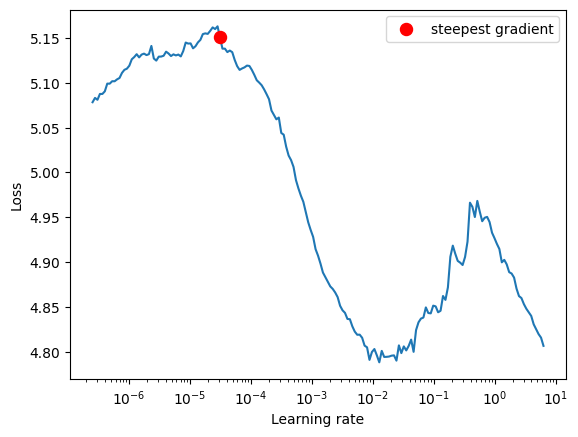


LR Finder Analysis:
Minimum loss at LR: 1.28e-02
Suggested max_lr range: 1.28e-03 to 4.25e-03

For CIFAR-100 + ResNet, proven baseline max_lr = 0.1


In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Data
train_transform, test_transform = get_transforms()

# Load base datasets
train_base = datasets.CIFAR100(root='./data', train=True, download=True)
test_base = datasets.CIFAR100(root='./data', train=False, download=True)

# Wrap with Albumentations
train_dataset = CIFAR100Dataset(train_base, transform=train_transform)
test_dataset = CIFAR100Dataset(test_base, transform=test_transform)

batch_size = 128 if torch.cuda.is_available() else 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2, pin_memory=True)

# Model
model = ResNet_44(num_classes=100).to(device)
print(f'\nModel: ResNet-44')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# ==================== LR FINDER ====================
print('\n' + '='*50)
print('Running LR Finder...')
print('='*50)

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=200, step_mode='exp')

# Plot and analyze
lr_finder.plot()

# Get suggested LR
lrs = lr_finder.history['lr']
losses = lr_finder.history['loss']

# Find minimum loss point
min_loss_idx = np.argmin(losses)
min_loss_lr = lrs[min_loss_idx]

# For OneCycleLR, use 1/10th to 1/3rd of the min loss LR as max_lr
# This is Leslie Smith's recommendation
suggested_lr_low = min_loss_lr / 10
suggested_lr_high = min_loss_lr / 3

print(f'\nLR Finder Analysis:')
print(f'Minimum loss at LR: {min_loss_lr:.2e}')
print(f'Suggested max_lr range: {suggested_lr_low:.2e} to {suggested_lr_high:.2e}')
print(f'\nFor CIFAR-100 + ResNet, proven baseline max_lr = 0.1')

lr_finder.reset()


Using max_lr: 0.1 (proven baseline)

Training for 100 epochs
Max LR: 0.1
Batch size: 128

EPOCH: 0



Epoch 0: 100%|██████████| 391/391 [01:27<00:00,  4.45it/s, Loss=4.0320, Batch_id=390, Accuracy=4.18]



Test set: Average loss: 4.0329, Accuracy: 1014/10000 (10.14%)

✓ Best model saved with accuracy: 10.14%

EPOCH: 1



Epoch 1: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=3.8738, Batch_id=390, Accuracy=8.59]



Test set: Average loss: 3.8557, Accuracy: 1471/10000 (14.71%)

✓ Best model saved with accuracy: 14.71%

EPOCH: 2



Epoch 2: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=4.1764, Batch_id=390, Accuracy=11.56]



Test set: Average loss: 3.6002, Accuracy: 1841/10000 (18.41%)

✓ Best model saved with accuracy: 18.41%

EPOCH: 3



Epoch 3: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=3.4399, Batch_id=390, Accuracy=14.56]



Test set: Average loss: 3.5176, Accuracy: 2164/10000 (21.64%)

✓ Best model saved with accuracy: 21.64%

EPOCH: 4



Epoch 4: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=4.2545, Batch_id=390, Accuracy=16.88]



Test set: Average loss: 3.2991, Accuracy: 2592/10000 (25.92%)

✓ Best model saved with accuracy: 25.92%

EPOCH: 5



Epoch 5: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=4.2131, Batch_id=390, Accuracy=19.97]



Test set: Average loss: 3.3678, Accuracy: 2658/10000 (26.58%)

✓ Best model saved with accuracy: 26.58%

EPOCH: 6



Epoch 6: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=3.6779, Batch_id=390, Accuracy=22.16]



Test set: Average loss: 3.1907, Accuracy: 2776/10000 (27.76%)

✓ Best model saved with accuracy: 27.76%

EPOCH: 7



Epoch 7: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=3.4821, Batch_id=390, Accuracy=25.22]



Test set: Average loss: 2.8959, Accuracy: 3551/10000 (35.51%)

✓ Best model saved with accuracy: 35.51%

EPOCH: 8



Epoch 8: 100%|██████████| 391/391 [01:28<00:00,  4.40it/s, Loss=4.0097, Batch_id=390, Accuracy=28.18]



Test set: Average loss: 3.1314, Accuracy: 3149/10000 (31.49%)

EPOCH: 9



Epoch 9: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.7717, Batch_id=390, Accuracy=29.42]



Test set: Average loss: 2.7926, Accuracy: 3890/10000 (38.90%)

✓ Best model saved with accuracy: 38.90%

EPOCH: 10



Epoch 10: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.7377, Batch_id=390, Accuracy=31.39]



Test set: Average loss: 2.5196, Accuracy: 4483/10000 (44.83%)

✓ Best model saved with accuracy: 44.83%

EPOCH: 11



Epoch 11: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=3.8382, Batch_id=390, Accuracy=32.42]



Test set: Average loss: 2.6173, Accuracy: 4425/10000 (44.25%)

EPOCH: 12



Epoch 12: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.5220, Batch_id=390, Accuracy=34.90]



Test set: Average loss: 2.4185, Accuracy: 4808/10000 (48.08%)

✓ Best model saved with accuracy: 48.08%

EPOCH: 13



Epoch 13: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.3182, Batch_id=390, Accuracy=36.57]



Test set: Average loss: 2.4078, Accuracy: 4884/10000 (48.84%)

✓ Best model saved with accuracy: 48.84%

EPOCH: 14



Epoch 14: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.5413, Batch_id=390, Accuracy=37.82]



Test set: Average loss: 2.4714, Accuracy: 4710/10000 (47.10%)

EPOCH: 15



Epoch 15: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.3680, Batch_id=390, Accuracy=40.23]



Test set: Average loss: 2.3489, Accuracy: 5032/10000 (50.32%)

✓ Best model saved with accuracy: 50.32%

EPOCH: 16



Epoch 16: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=3.9193, Batch_id=390, Accuracy=38.63]



Test set: Average loss: 2.4856, Accuracy: 4713/10000 (47.13%)

EPOCH: 17



Epoch 17: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.1073, Batch_id=390, Accuracy=40.60]



Test set: Average loss: 2.2287, Accuracy: 5383/10000 (53.83%)

✓ Best model saved with accuracy: 53.83%

EPOCH: 18



Epoch 18: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.9299, Batch_id=390, Accuracy=41.72]



Test set: Average loss: 2.2685, Accuracy: 5270/10000 (52.70%)

EPOCH: 19



Epoch 19: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.4052, Batch_id=390, Accuracy=43.04]



Test set: Average loss: 2.2502, Accuracy: 5327/10000 (53.27%)

EPOCH: 20



Epoch 20: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.3650, Batch_id=390, Accuracy=43.24]



Test set: Average loss: 2.3398, Accuracy: 5140/10000 (51.40%)

EPOCH: 21



Epoch 21: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.1778, Batch_id=390, Accuracy=42.79]



Test set: Average loss: 2.3108, Accuracy: 5180/10000 (51.80%)

EPOCH: 22



Epoch 22: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=3.4100, Batch_id=390, Accuracy=43.37]



Test set: Average loss: 2.2022, Accuracy: 5523/10000 (55.23%)

✓ Best model saved with accuracy: 55.23%

EPOCH: 23



Epoch 23: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.9037, Batch_id=390, Accuracy=43.91]



Test set: Average loss: 2.3324, Accuracy: 5145/10000 (51.45%)

EPOCH: 24



Epoch 24: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.0720, Batch_id=390, Accuracy=45.20]



Test set: Average loss: 2.3684, Accuracy: 5036/10000 (50.36%)

EPOCH: 25



Epoch 25: 100%|██████████| 391/391 [01:28<00:00,  4.41it/s, Loss=2.0422, Batch_id=390, Accuracy=44.72]



Test set: Average loss: 2.3951, Accuracy: 5079/10000 (50.79%)

EPOCH: 26



Epoch 26: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.3889, Batch_id=390, Accuracy=45.79]



Test set: Average loss: 2.1785, Accuracy: 5613/10000 (56.13%)

✓ Best model saved with accuracy: 56.13%

EPOCH: 27



Epoch 27: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.4488, Batch_id=390, Accuracy=46.10]



Test set: Average loss: 2.3158, Accuracy: 5215/10000 (52.15%)

EPOCH: 28



Epoch 28: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.2558, Batch_id=390, Accuracy=45.69]



Test set: Average loss: 2.2956, Accuracy: 5266/10000 (52.66%)

EPOCH: 29



Epoch 29: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.2002, Batch_id=390, Accuracy=45.56]



Test set: Average loss: 2.5615, Accuracy: 4677/10000 (46.77%)

EPOCH: 30



Epoch 30: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.2750, Batch_id=390, Accuracy=45.92]



Test set: Average loss: 2.2214, Accuracy: 5521/10000 (55.21%)

EPOCH: 31



Epoch 31: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=2.0928, Batch_id=390, Accuracy=47.44]



Test set: Average loss: 2.1618, Accuracy: 5642/10000 (56.42%)

✓ Best model saved with accuracy: 56.42%

EPOCH: 32



Epoch 32: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0063, Batch_id=390, Accuracy=47.95]



Test set: Average loss: 2.1969, Accuracy: 5511/10000 (55.11%)

EPOCH: 33



Epoch 33: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.1189, Batch_id=390, Accuracy=47.61]



Test set: Average loss: 2.1899, Accuracy: 5618/10000 (56.18%)

EPOCH: 34



Epoch 34: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.1388, Batch_id=390, Accuracy=47.96]



Test set: Average loss: 2.2813, Accuracy: 5377/10000 (53.77%)

EPOCH: 35



Epoch 35: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0055, Batch_id=390, Accuracy=48.45]



Test set: Average loss: 2.0819, Accuracy: 5892/10000 (58.92%)

✓ Best model saved with accuracy: 58.92%

EPOCH: 36



Epoch 36: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0863, Batch_id=390, Accuracy=48.56]



Test set: Average loss: 2.2827, Accuracy: 5401/10000 (54.01%)

EPOCH: 37



Epoch 37: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=1.8856, Batch_id=390, Accuracy=48.63]



Test set: Average loss: 2.3322, Accuracy: 5258/10000 (52.58%)

EPOCH: 38



Epoch 38: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.2479, Batch_id=390, Accuracy=48.44]



Test set: Average loss: 2.1453, Accuracy: 5722/10000 (57.22%)

EPOCH: 39



Epoch 39: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.1947, Batch_id=390, Accuracy=48.82]



Test set: Average loss: 2.1175, Accuracy: 5817/10000 (58.17%)

EPOCH: 40



Epoch 40: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0333, Batch_id=390, Accuracy=48.17]



Test set: Average loss: 2.0638, Accuracy: 5944/10000 (59.44%)

✓ Best model saved with accuracy: 59.44%

EPOCH: 41



Epoch 41: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.9552, Batch_id=390, Accuracy=49.17]



Test set: Average loss: 2.2107, Accuracy: 5570/10000 (55.70%)

EPOCH: 42



Epoch 42: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.8746, Batch_id=390, Accuracy=48.08]



Test set: Average loss: 2.1834, Accuracy: 5568/10000 (55.68%)

EPOCH: 43



Epoch 43: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0214, Batch_id=390, Accuracy=49.93]



Test set: Average loss: 2.0225, Accuracy: 6122/10000 (61.22%)

✓ Best model saved with accuracy: 61.22%

EPOCH: 44



Epoch 44: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0288, Batch_id=390, Accuracy=50.52]



Test set: Average loss: 1.9971, Accuracy: 6146/10000 (61.46%)

✓ Best model saved with accuracy: 61.46%

EPOCH: 45



Epoch 45: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=3.5702, Batch_id=390, Accuracy=49.33]



Test set: Average loss: 2.2647, Accuracy: 5441/10000 (54.41%)

EPOCH: 46



Epoch 46: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=3.4298, Batch_id=390, Accuracy=50.59]



Test set: Average loss: 2.1561, Accuracy: 5780/10000 (57.80%)

EPOCH: 47



Epoch 47: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=3.3030, Batch_id=390, Accuracy=50.68]



Test set: Average loss: 2.3459, Accuracy: 5266/10000 (52.66%)

EPOCH: 48



Epoch 48: 100%|██████████| 391/391 [01:27<00:00,  4.45it/s, Loss=3.2473, Batch_id=390, Accuracy=51.15]



Test set: Average loss: 2.0795, Accuracy: 5926/10000 (59.26%)

EPOCH: 49



Epoch 49: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.9280, Batch_id=390, Accuracy=50.22]



Test set: Average loss: 2.0201, Accuracy: 6032/10000 (60.32%)

EPOCH: 50



Epoch 50: 100%|██████████| 391/391 [01:27<00:00,  4.44it/s, Loss=1.9770, Batch_id=390, Accuracy=50.07]



Test set: Average loss: 2.0237, Accuracy: 6073/10000 (60.73%)

EPOCH: 51



Epoch 51: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.7583, Batch_id=390, Accuracy=50.81]



Test set: Average loss: 1.9304, Accuracy: 6339/10000 (63.39%)

✓ Best model saved with accuracy: 63.39%

EPOCH: 52



Epoch 52: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.9241, Batch_id=390, Accuracy=51.75]



Test set: Average loss: 2.0074, Accuracy: 6103/10000 (61.03%)

EPOCH: 53



Epoch 53: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.7628, Batch_id=390, Accuracy=50.91]



Test set: Average loss: 1.9133, Accuracy: 6354/10000 (63.54%)

✓ Best model saved with accuracy: 63.54%

EPOCH: 54



Epoch 54: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=3.0703, Batch_id=390, Accuracy=51.70]



Test set: Average loss: 2.0311, Accuracy: 6069/10000 (60.69%)

EPOCH: 55



Epoch 55: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.8270, Batch_id=390, Accuracy=50.93]



Test set: Average loss: 1.9516, Accuracy: 6323/10000 (63.23%)

EPOCH: 56



Epoch 56: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.8845, Batch_id=390, Accuracy=53.72]



Test set: Average loss: 2.0121, Accuracy: 6144/10000 (61.44%)

EPOCH: 57



Epoch 57: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=3.2073, Batch_id=390, Accuracy=52.23]



Test set: Average loss: 1.9078, Accuracy: 6390/10000 (63.90%)

✓ Best model saved with accuracy: 63.90%

EPOCH: 58



Epoch 58: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0404, Batch_id=390, Accuracy=54.20]



Test set: Average loss: 2.0185, Accuracy: 6155/10000 (61.55%)

EPOCH: 59



Epoch 59: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=2.7457, Batch_id=390, Accuracy=53.86]



Test set: Average loss: 1.9363, Accuracy: 6354/10000 (63.54%)

EPOCH: 60



Epoch 60: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.8779, Batch_id=390, Accuracy=51.35]



Test set: Average loss: 1.9556, Accuracy: 6316/10000 (63.16%)

EPOCH: 61



Epoch 61: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.9055, Batch_id=390, Accuracy=54.09]



Test set: Average loss: 2.0003, Accuracy: 6130/10000 (61.30%)

EPOCH: 62



Epoch 62: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.8481, Batch_id=390, Accuracy=54.79]



Test set: Average loss: 2.0194, Accuracy: 6097/10000 (60.97%)

EPOCH: 63



Epoch 63: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.7939, Batch_id=390, Accuracy=52.64]



Test set: Average loss: 1.9269, Accuracy: 6388/10000 (63.88%)

EPOCH: 64



Epoch 64: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.8686, Batch_id=390, Accuracy=53.88]



Test set: Average loss: 1.9865, Accuracy: 6191/10000 (61.91%)

EPOCH: 65



Epoch 65: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=3.1202, Batch_id=390, Accuracy=55.07]



Test set: Average loss: 1.9223, Accuracy: 6417/10000 (64.17%)

✓ Best model saved with accuracy: 64.17%

EPOCH: 66



Epoch 66: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.8018, Batch_id=390, Accuracy=53.95]



Test set: Average loss: 1.8665, Accuracy: 6579/10000 (65.79%)

✓ Best model saved with accuracy: 65.79%

EPOCH: 67



Epoch 67: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.8541, Batch_id=390, Accuracy=55.44]



Test set: Average loss: 1.8228, Accuracy: 6643/10000 (66.43%)

✓ Best model saved with accuracy: 66.43%

EPOCH: 68



Epoch 68: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.8695, Batch_id=390, Accuracy=56.98]



Test set: Average loss: 1.8317, Accuracy: 6684/10000 (66.84%)

✓ Best model saved with accuracy: 66.84%

EPOCH: 69



Epoch 69: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=2.1486, Batch_id=390, Accuracy=56.24]



Test set: Average loss: 1.8487, Accuracy: 6572/10000 (65.72%)

EPOCH: 70



Epoch 70: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.9915, Batch_id=390, Accuracy=55.75]



Test set: Average loss: 1.8373, Accuracy: 6687/10000 (66.87%)

✓ Best model saved with accuracy: 66.87%

EPOCH: 71



Epoch 71: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.7183, Batch_id=390, Accuracy=56.81]



Test set: Average loss: 1.8867, Accuracy: 6512/10000 (65.12%)

EPOCH: 72



Epoch 72: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.7208, Batch_id=390, Accuracy=58.03]



Test set: Average loss: 1.7929, Accuracy: 6744/10000 (67.44%)

✓ Best model saved with accuracy: 67.44%

EPOCH: 73



Epoch 73: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s, Loss=3.0230, Batch_id=390, Accuracy=57.97]



Test set: Average loss: 1.8592, Accuracy: 6577/10000 (65.77%)

EPOCH: 74



Epoch 74: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=3.3560, Batch_id=390, Accuracy=58.55]



Test set: Average loss: 1.8492, Accuracy: 6606/10000 (66.06%)

EPOCH: 75



Epoch 75: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.5404, Batch_id=390, Accuracy=57.94]



Test set: Average loss: 1.7847, Accuracy: 6833/10000 (68.33%)

✓ Best model saved with accuracy: 68.33%

EPOCH: 76



Epoch 76: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.0272, Batch_id=390, Accuracy=59.61]



Test set: Average loss: 1.6894, Accuracy: 7081/10000 (70.81%)

✓ Best model saved with accuracy: 70.81%

EPOCH: 77



Epoch 77: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.6407, Batch_id=390, Accuracy=61.09]



Test set: Average loss: 1.7095, Accuracy: 7030/10000 (70.30%)

EPOCH: 78



Epoch 78: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=3.3469, Batch_id=390, Accuracy=59.20]



Test set: Average loss: 1.7423, Accuracy: 6939/10000 (69.39%)

EPOCH: 79



Epoch 79: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.7026, Batch_id=390, Accuracy=60.52]



Test set: Average loss: 1.6834, Accuracy: 7119/10000 (71.19%)

✓ Best model saved with accuracy: 71.19%

EPOCH: 80



Epoch 80: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=3.2844, Batch_id=390, Accuracy=62.32]



Test set: Average loss: 1.7286, Accuracy: 7020/10000 (70.20%)

EPOCH: 81



Epoch 81: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.6393, Batch_id=390, Accuracy=60.11]



Test set: Average loss: 1.7309, Accuracy: 6968/10000 (69.68%)

EPOCH: 82



Epoch 82: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=2.7331, Batch_id=390, Accuracy=62.80]



Test set: Average loss: 1.6027, Accuracy: 7376/10000 (73.76%)

✓ Best model saved with accuracy: 73.76%

EPOCH: 83



Epoch 83: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.4353, Batch_id=390, Accuracy=64.99]



Test set: Average loss: 1.6163, Accuracy: 7367/10000 (73.67%)

EPOCH: 84



Epoch 84: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=3.2135, Batch_id=390, Accuracy=64.05]



Test set: Average loss: 1.6498, Accuracy: 7229/10000 (72.29%)

EPOCH: 85



Epoch 85: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.4455, Batch_id=390, Accuracy=66.60]



Test set: Average loss: 1.5483, Accuracy: 7520/10000 (75.20%)

✓ Best model saved with accuracy: 75.20%

EPOCH: 86



Epoch 86: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.4513, Batch_id=390, Accuracy=68.44]



Test set: Average loss: 1.5457, Accuracy: 7541/10000 (75.41%)

✓ Best model saved with accuracy: 75.41%

EPOCH: 87



Epoch 87: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.4062, Batch_id=390, Accuracy=69.28]



Test set: Average loss: 1.5387, Accuracy: 7540/10000 (75.40%)

EPOCH: 88



Epoch 88: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=3.0650, Batch_id=390, Accuracy=67.69]



Test set: Average loss: 1.5135, Accuracy: 7637/10000 (76.37%)

✓ Best model saved with accuracy: 76.37%

EPOCH: 89



Epoch 89: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.2267, Batch_id=390, Accuracy=68.80]



Test set: Average loss: 1.4838, Accuracy: 7729/10000 (77.29%)

✓ Best model saved with accuracy: 77.29%

EPOCH: 90



Epoch 90: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.1367, Batch_id=390, Accuracy=71.24]



Test set: Average loss: 1.4427, Accuracy: 7857/10000 (78.57%)

✓ Best model saved with accuracy: 78.57%

EPOCH: 91



Epoch 91: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.1403, Batch_id=390, Accuracy=73.00]



Test set: Average loss: 1.4313, Accuracy: 7908/10000 (79.08%)

✓ Best model saved with accuracy: 79.08%

EPOCH: 92



Epoch 92: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.1074, Batch_id=390, Accuracy=73.78]



Test set: Average loss: 1.4163, Accuracy: 7916/10000 (79.16%)

✓ Best model saved with accuracy: 79.16%

EPOCH: 93



Epoch 93: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.0696, Batch_id=390, Accuracy=74.57]



Test set: Average loss: 1.4407, Accuracy: 7914/10000 (79.14%)

EPOCH: 94



Epoch 94: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.0754, Batch_id=390, Accuracy=76.69]



Test set: Average loss: 1.4073, Accuracy: 7994/10000 (79.94%)

✓ Best model saved with accuracy: 79.94%

EPOCH: 95



Epoch 95: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=0.9780, Batch_id=390, Accuracy=77.61]



Test set: Average loss: 1.3910, Accuracy: 8031/10000 (80.31%)

✓ Best model saved with accuracy: 80.31%

EPOCH: 96



Epoch 96: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=2.7766, Batch_id=390, Accuracy=76.94]



Test set: Average loss: 1.3883, Accuracy: 8060/10000 (80.60%)

✓ Best model saved with accuracy: 80.60%

EPOCH: 97



Epoch 97: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.4671, Batch_id=390, Accuracy=76.22]



Test set: Average loss: 1.3920, Accuracy: 8066/10000 (80.66%)

✓ Best model saved with accuracy: 80.66%

EPOCH: 98



Epoch 98: 100%|██████████| 391/391 [01:28<00:00,  4.43it/s, Loss=1.8318, Batch_id=390, Accuracy=77.80]



Test set: Average loss: 1.3779, Accuracy: 8087/10000 (80.87%)

✓ Best model saved with accuracy: 80.87%

EPOCH: 99



Epoch 99: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s, Loss=1.2012, Batch_id=390, Accuracy=78.03]



Test set: Average loss: 1.3922, Accuracy: 8057/10000 (80.57%)



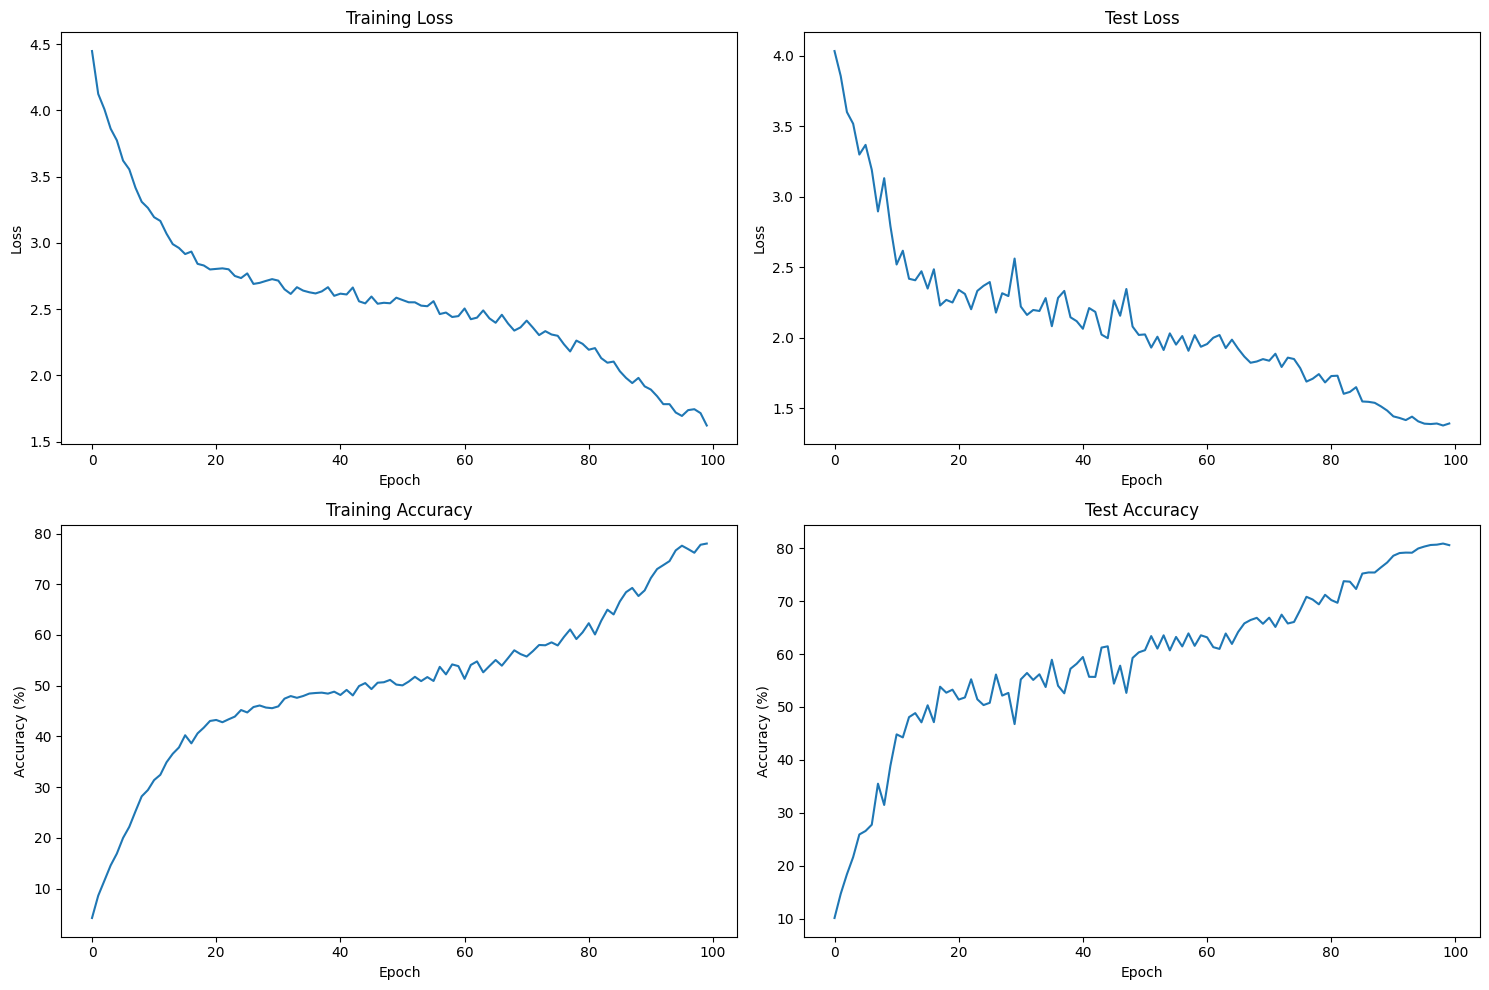


Training Complete!
Best Test Accuracy: 80.87%


In [10]:
EPOCHS = 100

max_lr = 0.1

print(f'\n{"="*50}')
print(f'Using max_lr: {max_lr} (proven baseline)')
print(f'{"="*50}')

# Recreate optimizer after LR finder
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=5e-4)

# OneCycleLR with cosine annealing
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,           # 30% warmup
    div_factor=25,           # initial_lr = max_lr/25
    final_div_factor=10000,  # final_lr = max_lr/10000
    anneal_strategy='cos'    # Cosine annealing
)

print('\n' + '='*50)
print(f'Training for {EPOCHS} epochs')
print(f'Max LR: {max_lr}')
print(f'Batch size: {batch_size}')
print('='*50 + '\n')

train_losses = []
test_losses = []
train_accs = []
test_accs = []
best_acc = 0.0

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}\n')

    train_loss, train_acc = train(model, device, train_loader, optimizer,
                                  epoch, scheduler, criterion, use_cutmix=True)
    test_loss, test_acc = test(model, device, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
        }, 'best_resnet44_cifar100.pth')
        print(f'✓ Best model saved with accuracy: {best_acc:.2f}%\n')

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")

axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy (%)")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")

axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy (%)")

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\n{"="*50}')
print(f'Training Complete!')
print(f'Best Test Accuracy: {best_acc:.2f}%')
print(f'{"="*50}')


In [11]:
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')

# Print model summary
try:
    from torchsummary import summary
    print('\nModel Architecture Summary:')
    summary(model, input_size=(3, 32, 32))
except ImportError:
    print('\nInstall torchsummary for detailed architecture: pip install torchsummary')
    print(f'Model structure:\n{model}')

Total parameters: 30,032,292

Model Architecture Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
     ResidualBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 3